# Введение в анализ данных
## НИУ ВШЭ, 2019-2020 учебный год

### Домашнее задание №4

Задание выполнил(а): (впишите свои фамилию и имя)

### Общая информация

__Дата выдачи:__ 24.05.2020

__Дедлайн:__ 23:59 07.06.2020


### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
min(\text{points}, 19)  \times 10 / 19,
$$

где points — количество баллов за обязательную часть, которое вы набрали. Максимальное число баллов, которое можно получить за обязательную часть — 19, а максимальное число дополнительных баллов, которые пойдут в бонус — 1.

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Инвайт для группы ИАД-4: zG1cIyT

Перед отправкой перезагрузите ноутбук и проверьте, что все ячейки могут быть последовательно выполнены. Ноутбук должен запускаться с использованием python 3.6+

In [6]:
import numpy as np
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## Random Forest своими руками (4 балла)

Реализуйте алгоритм случайного леса. В соответствии с построением алгоритма, ваша реализация должна сочетать в себе метод бэггинга и метод случайных подмножеств. Также она должна работать для двух типов задач: как для задачи регрессии, так и для задачи классификации.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn`.*

In [174]:
class RandomForest:
    def __init__(self, n_estimators, max_depth, max_features='sqrt', task_type='regression'):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        max_features - maximum features for each split in DecisionTree from sklearn
        task_type - 'regression' or 'classification'
        """
        self.task = task_type
        self.est = n_estimators
        self.depth = max_depth
        self.features = max_features
        self.task = task_type

    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        
        self.X = X_train
        self.y = y_train
        self.trees = [self.make_tree() for i in range(self.est)]
  
    def make_tree(self):
        self.features = int(np.sqrt(X.shape[1]))
        idxs = np.random.permutation(len(self.y))
        if self.task == 'regression':
            reg = DecisionTreeRegressor(max_features = self.features, max_depth = self.depth)  
            reg.fit(self.X[idxs], self.y[idxs])
            return reg

        elif self.task == 'classification':
            clas = DecisionTreeClassifier(max_features = self.features, max_depth = self.depth)
            clas.fit(self.X[idxs], self.y[idxs])
            return clas
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        if self.task == 'regression':
            y_pred = np.mean([t.predict(X_test) for t in self.trees], axis=0)
            return y_pred
        elif self.task == 'classification':
            y_pred = np.max([t.predict(X_test) for t in self.trees], axis=0)
            return y_pred
   

Проверьте вашу реализацию на задаче регрессии. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10.25 **(не меняйте параметры сида)**.

In [8]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [9]:
np.random.seed(19052019)

reg = RandomForest(n_estimators = 100, max_depth = 10, max_features='sqrt', task_type='regression')
reg.fit(X_train, y_train)
reg.predict(X_test)[:10]
mean_squared_error(reg.predict(X_test), y_test)

8.616535531589436

Проверьте вашу реализацию на задаче классификации. Подберите оптимальные гиперпараметры, чтобы получить accuracy > 0.83 **(не меняйте параметры сида)**.

In [175]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [186]:
np.random.seed(19052019)

clas = RandomForest(n_estimators = 10, max_depth = 10, max_features='sqrt', task_type='classification')
clas.fit(X_train, y_train)
accuracy_score(clas.predict(X_test), y_test)

0.8881118881118881

## Градиентный бустинг своими руками (5 + 1* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Однако чтобы получить дополнительный 1 балл вам нужно реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [ ]:
# это может помочь вам для поиска оптимальных gamma

from scipy.optimize import minimize

In [158]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        
        self.est = n_estimators
        self.depth = max_depth
        self.learn = learning_rate
        self.trees = [DecisionTreeRegressor(max_features='sqrt', max_depth=self.depth) for _ in range(self.est)]


    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        self.X = X_train
        self.y = y_train

        self.y_pred_train = np.mean(self.X)
        self.y_pred = self.y_pred_train
        for i in range(self.est):
            gradient = 2 * (self.y - self.y_pred_train)
            self.trees[i].fit(self.X, gradient)
            update = self.trees[i].predict(self.X)
            self.y_pred_train += np.multiply(self.learn, update)


    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = self.y_pred 
        for tree in self.trees:
            update = tree.predict(X_test)
            update = np.multiply(self.learn, update)
            y_pred += update
        return y_pred

Проверьте вашу реализацию. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10 как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**.

In [117]:
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [173]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators = 100, max_depth = 10, learning_rate=0.1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

8.549067744747498

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

## Ансамблевые методы (10 баллов)

Сопровождайте код изображениями и комментариями. Не игнорируйте вопросы, ваши выводы тоже оцениваются. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше. Не забывайте подписывать графики и будет вам счастье!

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

plt.style.use('ggplot')  
%matplotlib inline

**0. (0 баллов) ** Загрузите [датасет](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data), в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [232]:
data = pd.read_csv('diabetes.csv')

In [233]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

In "pregnancies" and "Outcome" zero is not the evidence of missed information, scince zero notation has a direct meaning in these cases: zero prenancies or no diabetes.

In other columns zero is the evidence of missed information

In [235]:
for col in data.columns[1:8]:
    mean = data[col].mean()
    data[col].replace(0, mean, inplace=True)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых. Ваши графики должны быть примерно такими:

![Image](https://d.radikal.ru/d03/2005/f8/0ffb9443cbcf.png)

In [293]:
column_matrix = np.array(data.columns).reshape(3, 3)
column_matrix

array([['Pregnancies', 'Glucose', 'BloodPressure'],
       ['SkinThickness', 'Insulin', 'BMI'],
       ['DiabetesPedigreeFunction', 'Age', 'Outcome']], dtype=object)

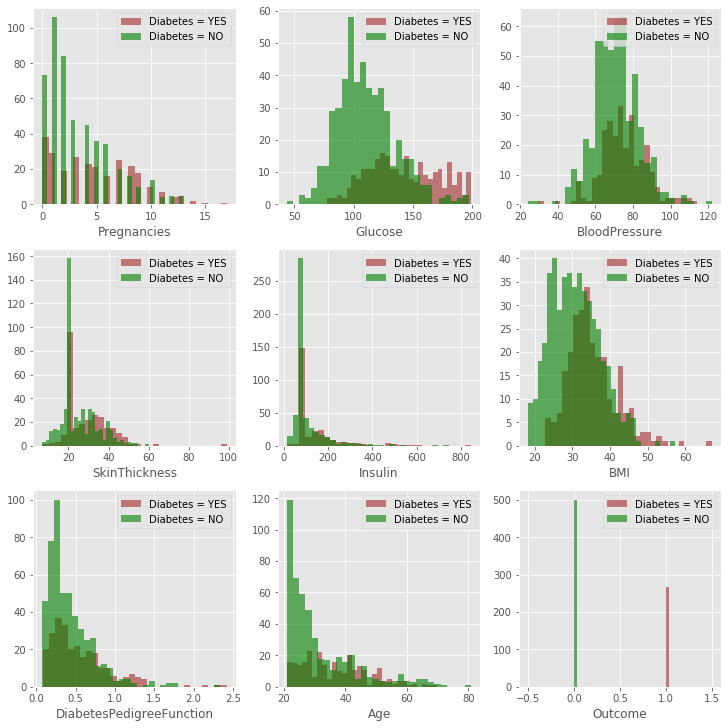

In [301]:
fig, ax = plt.subplots(nrows=3, ncols=3, constrained_layout=True)
fig.set_size_inches(10, 10)
for i in range(3):
    for j in range(3):
        ax[i, j].hist(data[(data.Outcome==1)][column_matrix[i, j]], bins=30, color='brown', alpha=0.6)
        ax[i, j].hist(data[(data.Outcome==0)][column_matrix[i, j]], bins=30, color='green', alpha=0.6)
        ax[i, j].set_xlabel(column_matrix[i, j])
        ax[i, j].legend(labels = ['Diabetes = YES', 'Diabetes = NO'])


**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите `BaggingClassifier` на деревьях (поставьте параметр `'base_estimator' = DecisionTreeClassifier()`) и `RandomForest`. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

*Подсказка: создайте отдельную функцию для вывода метрик качества.*

In [495]:
def metrics(y_pred, y_test):
    print(f'accuracy:  {accuracy_score(y_pred, y_test)}')
    print(f'precision: {precision_score(y_pred, y_test)}')
    print(f'recall:    {recall_score(y_pred, y_test)}')

In [445]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [390]:
X = data[['Pregnancies', 'Glucose',	'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',	'Age']]
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)

In [496]:
bc =  BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state=42), n_estimators=10, random_state=42)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
metrics(y_pred, y_test)

accuracy:  0.7316017316017316
precision: 0.5172413793103449
recall:    0.6923076923076923


In [497]:
rfc = RandomForestClassifier(n_estimators = 10, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
metrics(y_pred, y_test)

accuracy:  0.7792207792207793
precision: 0.5747126436781609
recall:    0.78125


**4. (2 балл)** Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров:
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Какие выводы вы можете сделать?

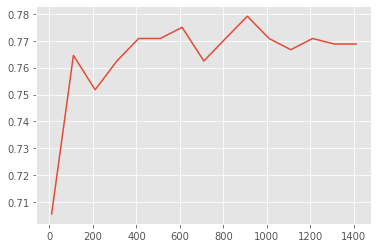

In [451]:
# n_estimators
estimators = np.arange(10, 1500, 100)
roc_auc = []
for est in estimators:
    ranfor = RandomForestClassifier(n_estimators = est)
    ranfor.fit(X_train, y_train)
    auc = roc_auc_score(np.array(ranfor.predict(X_test)), np.array(y_test.values))
    roc_auc.append(auc)
plt.plot(estimators, roc_auc)

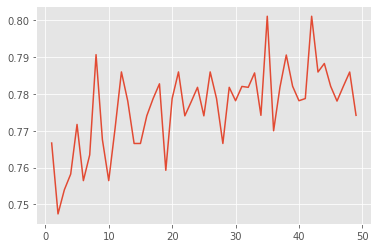

In [527]:
leafs = np.arange(1, 50)
roc_auc = []
for leaf in leafs:
    ranfor = RandomForestClassifier(n_estimators = 100, min_samples_leaf=leaf)
    ranfor.fit(X_train, y_train)
    auc = roc_auc_score(np.array(ranfor.predict(X_test)), np.array(y_test.values))
    roc_auc.append(auc)
plt.plot(leafs, roc_auc)

**5. (1 балл)**. Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим атрибутом случайного леса в библиотеке `sklearn`, чтобы построить `barplot`.

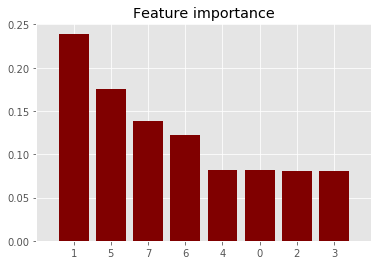

feature 1 is   Glucose,  importance of that feature is    23.93 %
feature 5 is   BMI,  importance of that feature is    17.51 %
feature 7 is   Age,  importance of that feature is    13.81 %
feature 6 is   DiabetesPedigreeFunction,  importance of that feature is    12.22 %
feature 4 is   Insulin,  importance of that feature is    8.23 %
feature 0 is   Pregnancies,  importance of that feature is    8.18 %
feature 2 is   BloodPressure,  importance of that feature is    8.07 %
feature 3 is   SkinThickness,  importance of that feature is    8.06 %


In [526]:
importance = rfc.feature_importances_
plt.figure(frameon=False)
plt.title('Feature importance')
indices = np.argsort(importance)[::-1]
plt.bar(range(X.shape[1]), importance[indices],
        color="maroon", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
importance = np.around(importance * 100, decimals=2)
for i in indices:
    print(f'feature {i} is   {data.columns[i]},  importance of that feature is    {importance[i]} %')

**6. (2 балла)** Обучите `HistGradientBoostingClassifier` и `GradientBoostingClassifier` из `sklearn`. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

`HistGradientBoostingClassifier`  работает значиетльно быстрее на больших базах данных (> 10000), также содержит внутреннюю поддержку работы с NaN

In [468]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier 

In [498]:
hgbc = HistGradientBoostingClassifier(max_iter=310, random_state = 42)
hgbc.fit(X_train, y_train)
y_pred = hgbc.predict(X_test)
metrics(y_pred, y_test)

accuracy:  0.7489177489177489
precision: 0.5747126436781609
recall:    0.704225352112676


In [499]:
gbc = GradientBoostingClassifier(n_estimators=310, random_state = 42)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
metrics(y_pred, y_test)

accuracy:  0.7402597402597403
precision: 0.5977011494252874
recall:    0.6753246753246753


**7. (1.5 балла)** Вспомните, что представляет из себя стэкинг моделей. Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классификатор из уже вами изученных на курсе. В качестве мета-классификатора (модели, обученной на ответах) используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

В данном пункте мы можете как написать код для стекинга сами, так и использовать [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

In [523]:
from sklearn.svm import LinearSVC

In [524]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
estimators = [
     ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
     ('svc', LinearSVC(random_state=42))
]
stc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stc.fit(X_train, y_train)
y_pred = stc.predict(X_test)
metrics(y_pred, y_test)

accuracy:  0.7402597402597403
precision: 0.47126436781609193
recall:    0.7454545454545455
